Federal University of Rio Grande do Sul (UFRGS)   
Postgraduate Program in Civil Engineering (PPGEC)
# MRPy - [M]ultivariate [R]andom [P]rocesses with P[y]thon  

_A Python Class for Stochastic Dynamic Analysis of Structural Systems_
---
_Prof. Marcelo M. Rocha, Dr.techn._ [(ORCID)](https://orcid.org/0000-0001-5640-1020)  
_Porto Alegre, RS, Brazil_ 


---
## Table of contents   

1. [Basic concept](#concept)  

2. [Constructors using external information (class methods)](#external)  
   2.1.  [Directly from ```ndarray```](#ndarray)  
   2.2.  [Reading from file](#from_file)  
   2.3.  [Simulate from spectral density](#from_spectrum)  
   2.4.  [Simulate from autocovariance](#from_autocov)  
   2.5.  [Simulate from pseudo-spectrum](#from_pseudo)  
   
3. [Constructors through modification (object methods)](#modifiers)   
   3.1.  [Remove mean value](#zero_mean)   
   3.2.  [Weighted superposition](#superpose)   
   3.3.  [Double length with trailing mean values](#double)  
   3.4.  [Extract segment](#extract)   
   3.5.  [Apply amplitude envelope](#envelope)   
   3.6.  [Moving average](#mov_average)  
   3.7.  [Bandpass and bandstop filters](#filtered)  
   3.8.  [Kanai/Tajimi filter for seismic acceleration](#Kanai)  
   3.9.  [Integration and differentiation in frequency domain](#calculus)  
   3.10. [Numerical solution of the dynamic equilibrium equation](#sdof)  
   3.11. [Free system response by random decrement](#random_decrement)  
   3.12. [Fit theoretical free response equation](#fit_decay)  

4. [Constructors from conceptual properties](#special)   
   4.1.  [Zero process](#zero_process)   
   4.2.  [Dirac's Delta function (unit impulse)](#dirac)   
   4.3.  [Heavisides function (unit step)](#heaviside)  
   4.4.  [White noise](#white_noise)  
   4.5.  [Pink noise](#pink_noise)  
 
5. [Methods for time series analysis](#properties)  
   5.1.  [Spectral density estimation (periodogram)](#periodogram)  
   5.2.  [Autocovariance and autocorrelation function](#autocov)  
   5.3.  [Pseudo-spectrum estimation](#pseudo)  
   5.4.  [Peak factor by Davenport's formula](#Davenport)  
   5.5.  [Peak factor by splitmax method](#splitmax)  

6. [Further methods](#extras)   
   6.1.  [Plot axis generation](#axis)   
   6.2.  [Pre-visualization plots](#plots)   
   6.3.  [Save to file](#to_file)   
   6.4.  [Periodogram to autocovariance conversions](#Sx2Cx)   
   6.5.  [Wind speed turbulence spectra](#wind_spectra)   
   6.6.  [UBC pseudo spectrum for seismic acceleration](#UBC_spectrum)   

7. [Examples of application](#examples)   
   7.1. [Modal analysis of structural systems](#modal)   
   7.2. [Wind turbulence response by NBR-6123](#NBR6123)   
   7.3. [Seismic response by UBC-1997](#UBC1997)   

___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from   MRPy import MRPy

## 1. Basic concept  <a name="concept"></a>

The ```MRPy``` class inherits from ```numpy.ndarray``` with the inclusion of a time attribute, which is optionally ```fs```, the sampling frequency, or ```Td```, the time span. Only one of these attribute must be specified at object construction, while the other will be automatically calculated using the relation:

\begin{equation}
 N = T_{\rm d} \; f_{\rm s}
\end{equation}  

The series length ```N``` must be an even integer. 

To better illustrate the concept, the basic construction syntax is exemplified below by 3 simulations of a Gaussian white noise, with a sampling frequency 512Hz:

In [2]:
arry = np.random.randn(16385, 3)

X    = MRPy(arry, fs=512)

print(type(X), X.shape)


<class 'MRPy.MRPy'> (3, 16384)


The input array contains any number of time series disposed as rows or columns, but internally the constructor will identify the largest dimension and force time series to be disposed as rows. This means that the provided array will be eventually transposed and the object content is always a matrix in the form:

\begin{equation}
{\mathbf X}(t) = 
\begin{bmatrix}
 X_1(t_1)    &  X_1(t_2)    &  X_1(t_3)    & \cdots  &  X_1(t_N)    \\
 X_2(t_1)    &  X_2(t_2)    &  X_2(t_3)    & \cdots  &  X_2(t_N)    \\
 X_3(t_1)    &  X_3(t_2)    &  X_3(t_3)    & \cdots  &  X_3(t_N)    \\
\cdots       & \cdots       & \cdots       & \cdots  & \cdots       \\
 X_{NX}(t_1) &  X_{NX}(t_2) &  X_{NX}(t_3) & \cdots  &  X_{NX}(t_N) \\
\end{bmatrix}
\end{equation}

From this definition, five attributes are internally assigned to the ```MRPy``` object ```X```:

In [3]:
X.printAttrib()

 fs = 512.0Hz
 Td = 32.0s

 NX = 3
 N  = 16384
 M  = 8193



where ```NX``` is the number of time series (number of matrix rows) and ```  M = N//2 + 1  ``` is the (odd) half length of each series in ```X```, corresponding to the length of spectral density and autocovariance estimators. These attributes are kept ready to be used by class methods presented in this notebook. 

If the series length ```N```  (number of columns) is not even, it will be truncated by 1 at construction, so _it is strongly recommended to provide only series with even lengths to avoid unintended truncation_.  

There are two main reasons for disposing the time series as rows in the ```MRPy``` array:

1. In the context of Structural Dynamics, both load and the response vectors are column vectors. Hence, ```MRPy``` arrays can undergo matrix operations as they are (for instance, they can be pre-multiplied by the modal shape matrix), each column being the load or the response at a given time step. Indeed, time series in MRPy instances are meant to be associated with system degrees of freedom or vibration modes.

2. Iteration over time series is straightforward with commands    
   ```for row in X:```   
   or   
   ```for kX, row in enumerate(X):```   
   which are frequently used along class methods code.


The inheritance from ```ndarray``` also ensures that many useful methods are kept available:

In [4]:
for kx, x in enumerate(X):
    print('{0}: mean = {1:7.4f},  std = {2:7.4f},  min = {3:7.4f},  max = {4:7.4f}'.format(
           kx, x.mean(), x.std(), x.min(), x.max()))

0: mean =  0.0054,  std =  0.9953,  min = -3.8985,  max =  3.8198
1: mean = -0.0083,  std =  0.9963,  min = -3.7074,  max =  3.7687
2: mean = -0.0054,  std =  0.9843,  min = -3.9776,  max =  3.7993


There is a quick visualization method available, which works for ```NX``` not larger than 12:

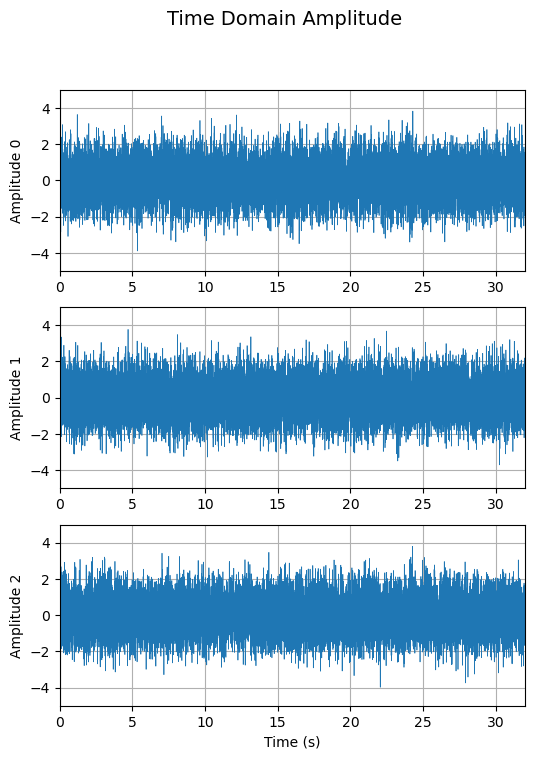

In [33]:
X.plot_time(fig=0, figsize=(6, 8), axis_t=[0, X.Td, -5, 5]);

There is also a quick visualization method in frequency domain (see section [2.3 Simulate from spectral density](#from_spectrum)):

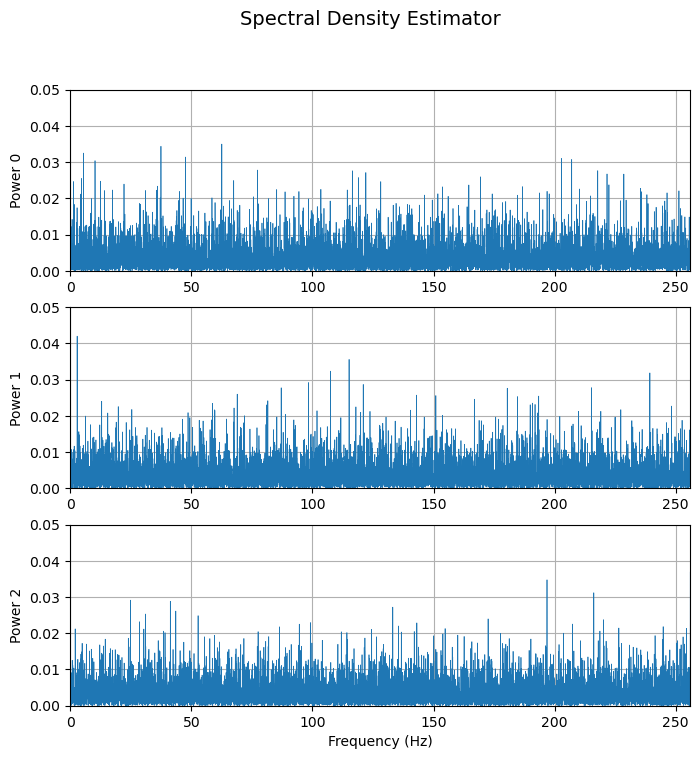

In [34]:
X.plot_freq(fig=1, figsize=(8, 8), axis_f=[0, X.fs/2, 0, 0.05]);

The next sections present the available methods for creating, modifying and operating with
```MRPy``` instances.


## 2. Constructors using external information (class methods)  <a name="external"></a>

### 2.1. Directly from ```ndarray```  <a name="ndarray"></a>

The example provided in the previous section illustrates how a ```MRPy``` instance can be directly created from a ```ndarray``` instance. The same can be accomplished by specifying the time span instead of the sampling frequency.   

Let's present another example, this time by combining some noise to a sinus function:


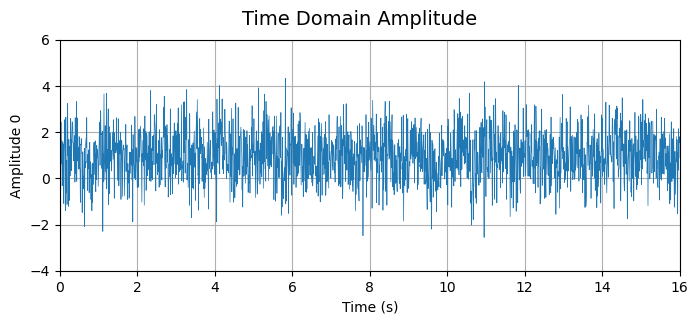

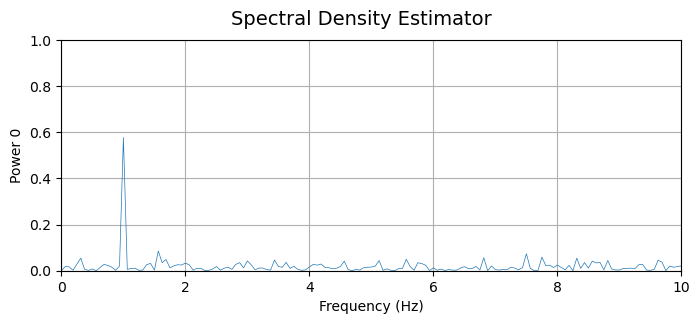

In [35]:
Td   =  16.      # signal duration (seconds)
N    =  2048     # number of sampling points

c0   =  1.0      # signal mean value
s0   =  0.3      # amplitude of harmonic part
f0   =  1.0      # frequency of harmonic part (Hz)
n0   =  1.0      # amplitude of gaussian noise

t    =  np.linspace(0, Td, N)
arry =  c0 + s0*np.sin(2*np.pi*f0*t) + n0*np.random.randn(N)

Y    =  MRPy(arry, Td=Td)

Y.plot_time(fig=2, figsize=(8, 3), axis_t=[0, Y.Td, -4, 6]);
Y.plot_freq(fig=3, figsize=(8, 3), axis_f=[0, 10.0,  0, 1]);

### 2.2. Reading from file  <a name="from_file"></a>

The method ```from_file()``` reads a ```MRPy``` object from a specified file. Some formats are implemented and others may be included to expand possibilities. The default file format is ```form='mrpy'```, which is a gnu zipped (```gzip```) file with a pickled object dumping (```pickle```). Files with this format can be generated as explained in section [5.2. Save to file](#to_file).

The other possibilities for parameter ```form``` are:

1. ```'excel'```: reads an Excel file (.xlsx) containing a ```pandas``` data frame in a sheet named ```MRPy```. The ```index``` attribute (first column) correspond to time instants and the further columns are the time series. Column headers are disregarded. This format allows easy communication with Excel.

2. ```'columns'```: reads a tab delimited ASCII file (.txt), where first column corresponds to time instants and following columns are the time series.

3. ```'invh'```: reads a comma delimited ASCII file (.csv), where first column corresponds to time instants (in seconds) while the last three columns correspond to accelerations in axis $x$, $y$ and $z$ measured with the cell phone app "iNVH" by Bosch. This is the format is used in classroom examples.

4. ```'MPU6050'```: reads a gnu zipped comma delimited ASCII file (.csv.gz), where first column corresponds to time instants (in seconds), the following three columns correspond to accelerations in axis $x$, $y$ and $z$, and the last three columns correspond to angular velocities in axis $x$, $y$ and $z$. This is the format used by a Raspberry Pi data logger reading a MPU6050 sensor that this author has developed for vibration monitoring. 

File extensions must not be included in the file name. ASCII files are read with ```numpy.genfromtxt()```. No matter the specified format, the data will undergo resampling to ensure an even sampling frequency. This means that all these formats allows for _slightly_ irregular sampling rates. The series are resampled through linear interpolation (using the  ```scipy``` function ```interp1d```) while their length an total time span are preserved. The resampling function is also available as a class method ```resampling()```:

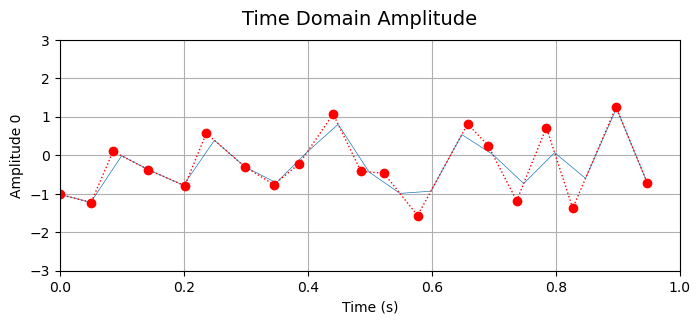

In [36]:
ti = np.arange(0,1,0.05) + 0.04*np.random.rand(20)  # irregular time steps!
ti = ti - ti[0]
Ei = np.random.randn(20)                            # simulation

E  = MRPy.resampling(ti, Ei);                       # resampling

E.plot_time(fig=4, figsize=(8, 3), axis_t=[0, 1, -3, 3]);        # resampled
plt.plot(ti, Ei, 'ro', ti, Ei, 'r:', lw=1);                      # original

Below is an example by reading a file generated with the accelerations recorded by the cell phone app "iNVH" from Bosch:

 fs = 99.7Hz
 Td = 23.0s

 NX = 3
 N  = 2296
 M  = 1149



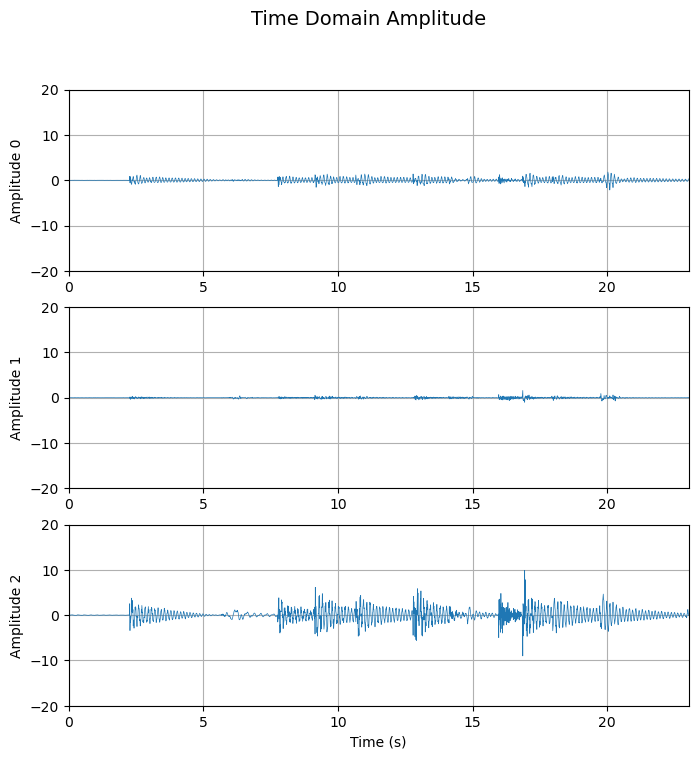

In [9]:
C  = MRPy.from_file('resources/iNVH001', form='invh');

C.printAttrib()

C.plot_time(fig=5, figsize=(8, 8), axis_t=[0, C.Td, -20, 20]);

File samples for all four available formats are included in the ```resources/``` folder that comes along with this notebook. 

### 2.3 Simulate from spectral density  <a name="from_spectrum"></a>

The power spectral density, $S_{X}(\omega)$, of a random process is related to the autocovariance function, $C_{X}(\tau)$, as a Fourier transform pair:

$$ S_{X}(\omega) = \frac{1}{2\pi} \int_{-\infty}^{+\infty}{C_{X}(\tau) e^{-i\omega \tau} \: d\tau} $$

$$ C_{X}(\tau) = \int_{-\infty}^{+\infty}{S_{X}(\omega) e^{i\omega \tau} \: d\omega} $$

By the definition used herein, the integral of the (one-sided) spectral density is the mean square value of the signal:

$$ \int_0^\infty {S_X(\omega) \: d\omega} = \sigma_X^2 + \mu_X^2 $$

The same can be obtained by setting $\tau = 0$ in the definition of $C_{X}(\tau)$ above:

$$  C_{X}(0) = \int_0^\infty {S_X(\omega) \: d\omega} = \sigma_X^2 + \mu_X^2 $$

As an example, let us simulate a wind speed turbulence, $v(t)$, according to Harris' spectral density, $S_V(f)$. In section [6.5. Wind speed turbulence spectra](#wind_spectra) a utility method is described that returns the following spectral density, but for now let us do it explicitly. 

$$ \frac{f S_V(f)}{\sigma_V^2} = \frac{0.6 Y}{\left( 2 + Y^2 \right)^{5/6}}$$
with:
\begin{align*}
 Y          &= 1800 f \;/\; \bar{V}_{10}     \\
 \sigma_V^2 &= 6.66 \; c_{\rm as} \; \bar{V}_{10}^2
\end{align*}

where $\sigma_V^2$ is the wind speed variance, $c_{\rm as}$ is the surface drag coefficient and $\bar{V}_{10}$ is the mean wind speed at 10m height.

Firstly, the frequency axis is generated:

In [10]:
cas =  6.5e-3                      # NBR-6123 category II
V10 =  20.                         # mean speed at 10m (m/s)
sV2 =  6.66*cas*(V10**2)           # wind speed variance   

fs  =  64.                         # sampling rate
N   =  8192                        # length of sample
M   =  N//2 + 1                    # length of periodogram
df  =  fs/M                        # frequency step

f   =  np.linspace(0, fs/2, M)     # frequency axis
Y   =  1800*f[1:]/V10              # avoiding zero division

To simulate a two-dimensional uncorrelated process, the spectral density must be calculated and replicated twice:

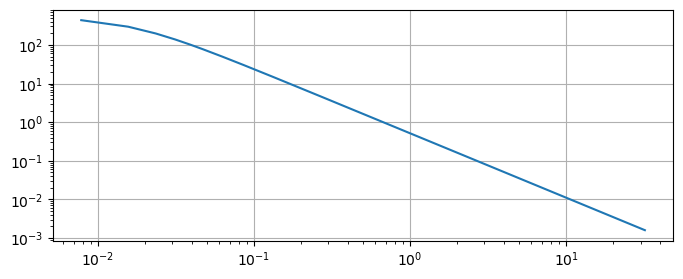

In [11]:
SV0       =  np.zeros((2, M))
SV0[0,1:] =  0.6*sV2*Y/((2 + Y**2)**(5/6))/f[1:]
SV0[1,1:] =  SV0[0,1:]  # (replicating)

plt.figure(6, figsize=(8, 3))
plt.grid(True)

h6  = plt.loglog(f[1:], SV0[0,1:])

Once the spectral density is defined, a ```MRPy``` instance can be simulated from it. Due to ```ndarray``` inheritance, the mean value can be directly added to the time series:

 fs = 64.0Hz
 Td = 128.0s

 NX = 2
 N  = 8192
 M  = 4097



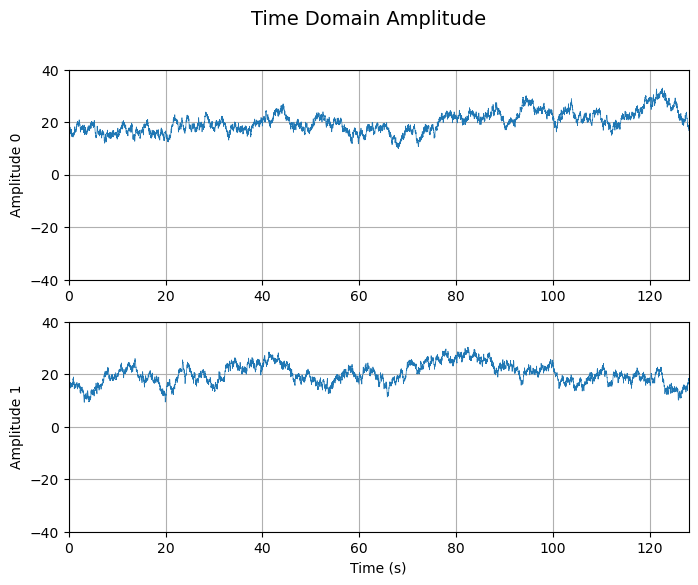

In [31]:
V  =  MRPy.from_periodogram(SV0, fs) + V10
V.printAttrib()

V.plot_time(fig=7, figsize=(8, 6), axis_t=[0, V.Td,  -40,  40]);

It must be emphasized that the time series simulated above are _uncorrelated_. Simulation of correlated multi-variate random processes shall be implemented in the future.

To check whether the simulated series indeed present the intended spectra, the periodogram estimation method can be used. 
The _periodogram_ is the most basic estimator of the (one-sided) spectral density of a time series. It makes use of FFT (_Fast Fourier Transform_, ```numpy.fft```) and a time scaling factor that depends on the sampling rate, ```fs```. 


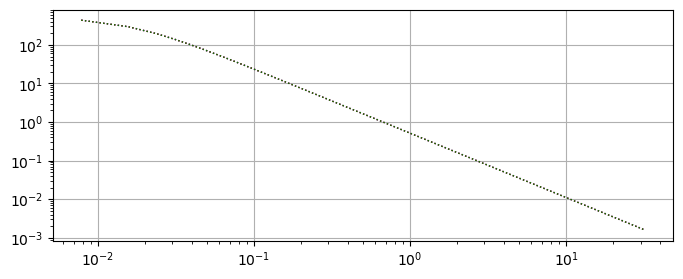

In [37]:
SV1, fs = V.periodogram()

plt.figure(8, figsize=(8, 3))
plt.grid(True)

plt.loglog(f[1:], SV0[0,1:], 'b:', lw=1);    # specified
plt.loglog(f[1:], SV1[0,1:], 'r:', lw=1);    # simulated 
plt.loglog(f[1:], SV1[1,1:], 'g:', lw=1);    # simulated

It can be finally confirmed that both simulated time series have _exactly_ the specified spectral density.

### 2.4 Simulate from autocovariance   <a name="from_autocov"></a>

The autocovariance, $C_X(\tau)$, may be explicitly provided as a ```ndarray```, or through a conversion from a spectral density, $S_X(\omega)$, using the class tool ```Sx2Cx()```. Let us illustrate this by using the same spectral density specified in the previous section.

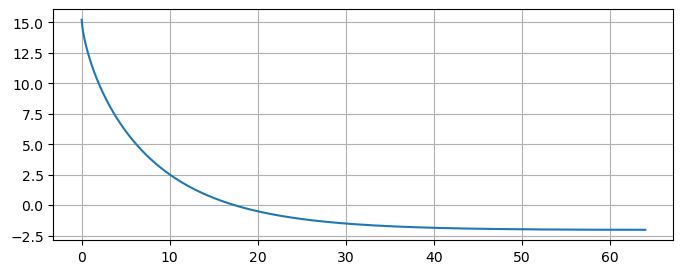

In [43]:
CV0, Tmax = MRPy.Sx2Cx(SV0, fs)
tau       = np.linspace(0, Tmax, M)

plt.figure(9, figsize=(8, 3))
plt.grid(True)

plt.plot(tau, CV0[0,:]);

Conversely, there is also a class method to go from autocovariance to spectral density:


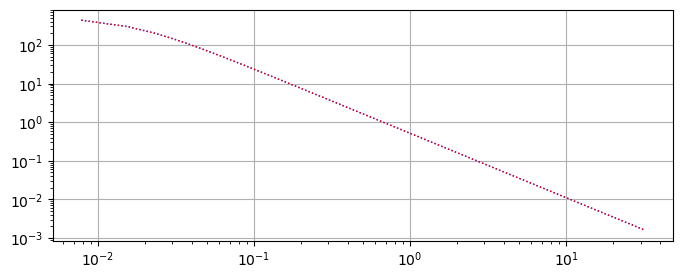

In [44]:
SV2, fs  = MRPy.Cx2Sx(CV0, Tmax)
f        = np.linspace(0, fs/2, M)

plt.figure(10, figsize=(8, 3))
plt.grid(True)

plt.loglog(f[1:], SV2[0,1:], 'b:', lw=1);
plt.loglog(f[1:], SV0[0,1:], 'r:', lw=1);

Once the autocovariance function is specified, simulation may be carried on as:

 fs = 64.0Hz
 Td = 128.0s

 NX = 2
 N  = 8192
 M  = 4097



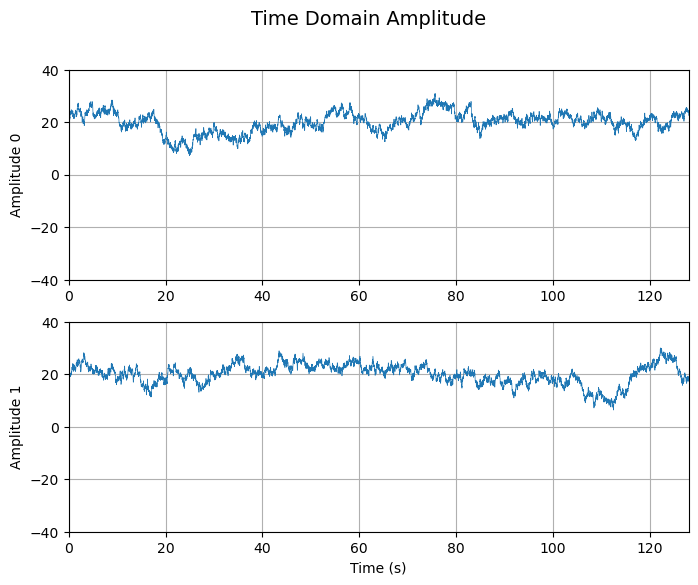

In [45]:
V   =  MRPy.from_autocov(CV0, Tmax) + V10
V.printAttrib()

V.plot_time(fig=11, figsize=(8, 6), axis_t=[0, V.Td,  -40,  40]);

To check wether the simulated series indeed present the intended autocovariance, the ```autocov()``` estimation method can be used. This method will call the periodogram estimator and carry out the due conversions. 

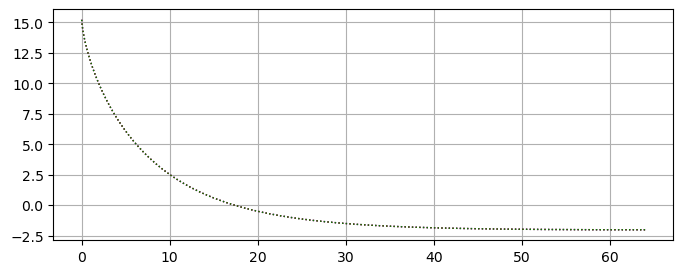

In [17]:
CV1, Tmax = V.autocov()

plt.figure(12, figsize=(8, 3))
plt.grid(True)

h12 = plt.plot(tau, CV0[0,:], 'b:', lw=1)     # specified
h12 = plt.plot(tau, CV1[0,:], 'r:', lw=1)     # estimated
h12 = plt.plot(tau, CV1[1,:], 'g:', lw=1)     # estimated

And it can be also confirmed that both simulated time series have _exactly_ the specified autocovariance function.

For any MRPy instance there is a quick method for checking the autocovariance function available. The plot, however, presents the _autocorrelation function_, which corresponds to the autocovariance scaled such that is value at origin (the variance) is normalized to unity.

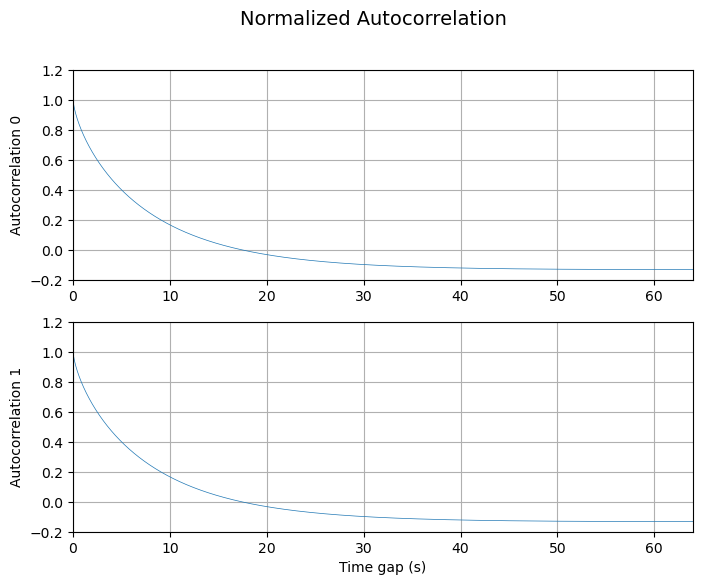

In [46]:
V.plot_corr(fig=13, figsize=(8, 6), axis_T=[0, Tmax, -0.2, 1.2]);

### 2.5 Simulate from pseudo-spectrum   <a name="from_pseudo"></a>

A pseudo spectrum is a function of the vibration period, $T$, of a one degree of freedom system. The spectrum corresponds to the system peak displacement response resulting from a given ground acceleration. The _pseudo-spectrum_ is the peak acceleration response calculated by multiplying the peak displacement by the squared frequency.
It is important to observe that, although the word _spectrum_ is used, this is not the same concept behind the spectral density definition (energy distribution across frequencies). 

As an example, firstly a seismic acceleration record is read from file:

 fs = 256.0Hz
 Td = 32.0s

 NX = 1
 N  = 8192
 M  = 4097



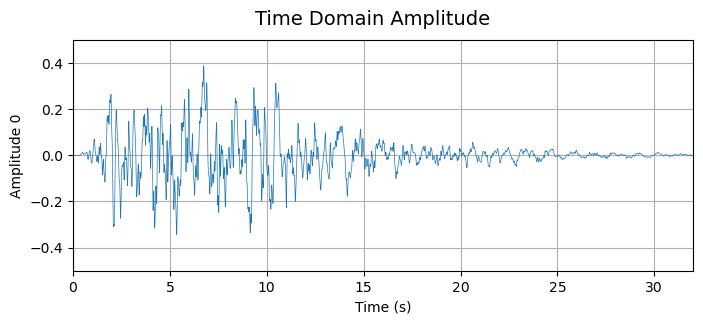

In [19]:
Acc = MRPy.from_file('resources/earthquake', form='columns'); 
Acc.printAttrib()

Acc.plot_time(fig=14, figsize=(8, 3), axis_t=[0, Acc.Td, -0.5, 0.5]);

Then the displacement response spectrum is estimated by the ```pseudo()``` object method. This method may take some time to compute, for the 1 d.o.f. system dynamic response must be evaluated for _each_ frequency step!

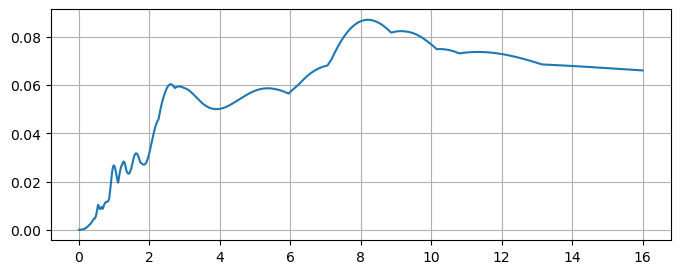

In [20]:
Su, Tmax = Acc.pseudo(zeta=0.05)         # system viscous damping must be specified, 5% is default
T        = np.linspace(0, Tmax, Acc.M)

plt.figure(15, figsize=(8, 3))
h15 = plt.plot(T, Su[0,:])
plt.grid(True)

There is also a method for quickly plotting this displacement spectrum:

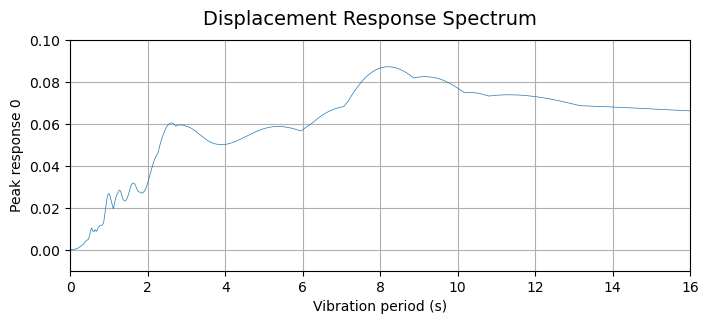

In [21]:
h16 = Acc.plot_pseudo(fig=16, figsize=(8, 3), axis_T=[0, Tmax, -0.01, 0.1])

This is, however, a peak displacement spectrum. To convert it to peak acceleration (pseudo-spectrum) it must be multiplied by the squared frequency:

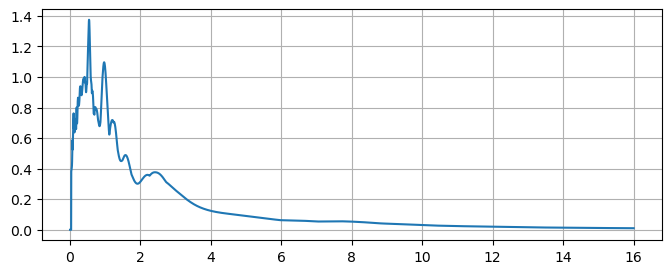

In [22]:
Sa       = np.zeros(Su.shape)
Sa[0,1:] = Su[0,1:]*(2*np.pi/T[1:])**2

plt.figure(17, figsize=(8, 3))
h17 = plt.plot(T, Sa[0,:])
plt.grid(True)


This estimated acceleration response spectrum corresponds to one single ground acceleration record. A collection of records lead to normalized spectra as provided by design codes. In section [6.6. UBC pseudo-spectrum for seismic acceleration](#UBC_spectrum) a utility method is described that returns a design spectrum from UBC code, but for now let us use the spectrum estimated above.

To simulate a ground acceleration sample from the specified pseudo-acceleration spectrum the ```from_pseudo()``` method is called.

 fs = 256.0Hz
 Td = 32.0s

 NX = 1
 N  = 8192
 M  = 4097



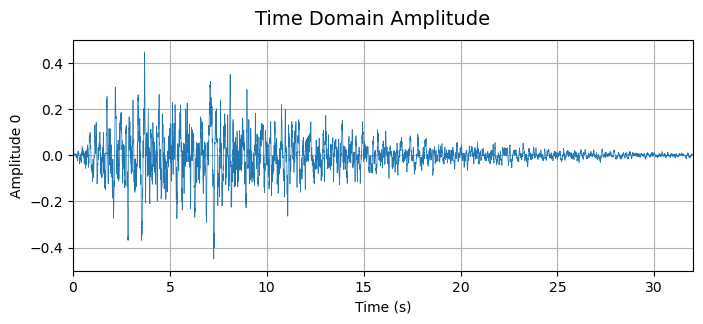

In [ ]:
T1 = 3.    # end of "attack" time
T2 = 8.    # end of "sustain" time
T0 = 8.    # time constant of the exponential amplitude decay

A0 = MRPy.from_pseudo(Sa, Tmax, (T1, T2, T0), zeta=0.05)
A0.printAttrib()

h18 = A0.plot_time(fig=18, figsize=(8, 3), axis_t=[0, A0.Td, -0.5, 0.5])

The specified acceleration pseudo-spectrum can be finally verified:

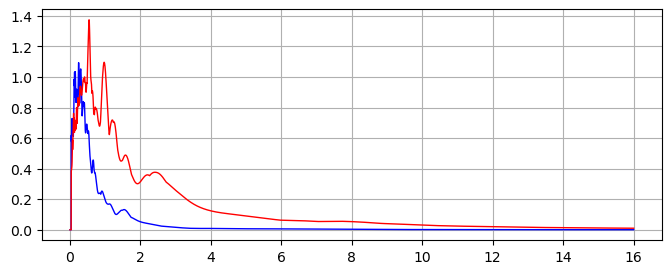

In [24]:
Su0, Tmax0 = A0.pseudo()
Sa0        = np.zeros(Su0.shape)
Sa0[0,1:]  = Su0[0,1:]*(2*np.pi/T[1:])**2

plt.figure(19, figsize=(8, 3))
h19 = plt.plot(T, Sa0[0,:], 'b', lw=1)
h19 = plt.plot(T, Sa [0,:], 'r', lw=1)
plt.grid(True)


---
## 3.  Constructors through modification (object methods) <a name="modifiers"></a>

### 3.1 Remove mean value  <a name="zero_mean"></a>




### 3.2 Extract a segment   <a name="extract"></a>

### 3.3.  Double length with trailing mean values  <a name="double"></a>

### 3.4.  Extract segment  <a name="extract"></a> 

### 3.5.  Apply amplitude envelope  <a name="envelope"></a> 

### 3.6.  Moving average  <a name="mov_average"></a>

### 3.7.  Bandpass and bandstop filters  <a name="filtered"></a>  

### 3.8.  Kanai/Tajimi filter for seismic acceleration  <a name="Kanai"></a>

### 3.9.  Integration and differentiation in frequency domain   <a name="calculus"></a>

A time signal frequently needs to be integrated or differentiated with respect to time. For instance, signals may be generated by sensors like accelerometers, which means that to obtain the (fluctuating part of) displacement it must be integrated twice. 

There are some issues with integrating a noisy signal, as the cumulative sum of random errors results in a _random walk_. 

Let us demonstrate it with:

Observe that, despite noise mean value being zero, there are large excursions with growing amplitude along time. The explanation is simple: the variance of the integrated process is the sum of variances of all previous samples, what means it is non-stationary and monotonically increasing.

To face this problem, the URP module provides frequency domain integral and derivative functions that allow the definition of a frequency band to be retained, while signal energy outside this band if fully disregarded. This means that whenever integrating a signal, the lower bound of this band may be specified as high enough to get rid of random walking. 

To exemplify the bandpass integration, we firstly integrate with the full signal band available:


... and now the band is restricted:

By comparing the two results (which corresponds to the _same_ signal simulation) it is possible to see that the low frequency content can be arbitrarily removed without further affecting the signal. The most suitable value for the high pass frequency (lower bound of given frequency range) must be chosen in order to get rid of drift without attenuating relevant signal information.

On the other hand, whenever differentiating a signal, the upper bound may be specified as low enough to get rid of high frequency noise intrinsic to numerical derivatives.

To demonstrate this funcionality, let us differentiate back the (high-pass) integrated signal of the previous section, but initially with the full available band:

It can be observed that the original signal was _apparently_ fully recovered, but we know that the low frequency content has been removed as observed by a non-zero mean square error.

Now we repeat the same operation, but getting rid of some undesirable high frequency signal content. Let us say that the upper bound of the available frequency range will be only 1/4 of the available:


and we finally check the integral of this signal:

from which it can be observed that now the integral not only has no drifting problem, but is also smoothed out due to the previous low-pass differentiation. Obviously the same integral could have been obtained from applying both lower and upper bounds at the same time.

### 3.10. Numerical solution of the dynamic equilibrium equation  <a name="sdof"></a>

### 3.11. Free system response by random decrement  <a name="random_decrement"></a> 

### 3.12. Fit theoretical free response equation  <a name="fit_decay"></a>

---
## 4. Constructors from idealized properties <a name="special"></a>

### 4.1.  Zero time series <a name="zeros"></a>


In [25]:
Z   = MRPy.zeros(NX=1, N=1024, fs=1024)
#f01 = Z.plot_time()


### 4.2.  Dirac's Delta function (unit impulse) <a name="dirac"></a>

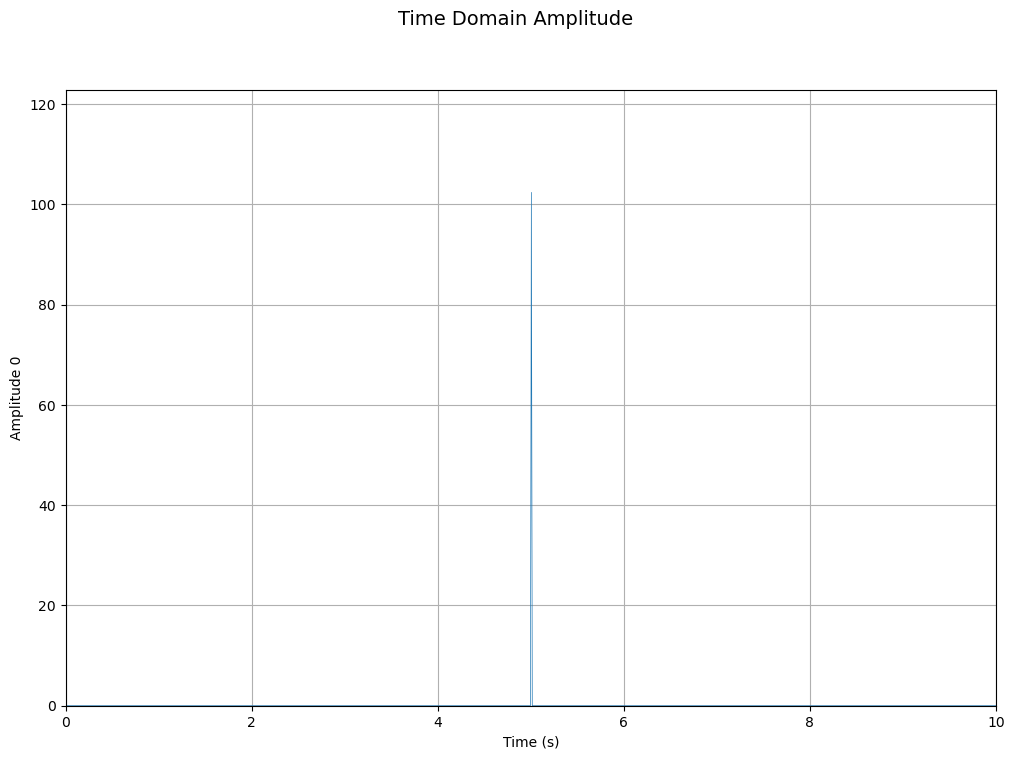

In [26]:
D   = MRPy.Dirac(NX=1, N=1024, t0=5, Td=10)
f02 = D.plot_time()


### 4.3. Heaviside's function (unit step) <a name="heaviside"></a>

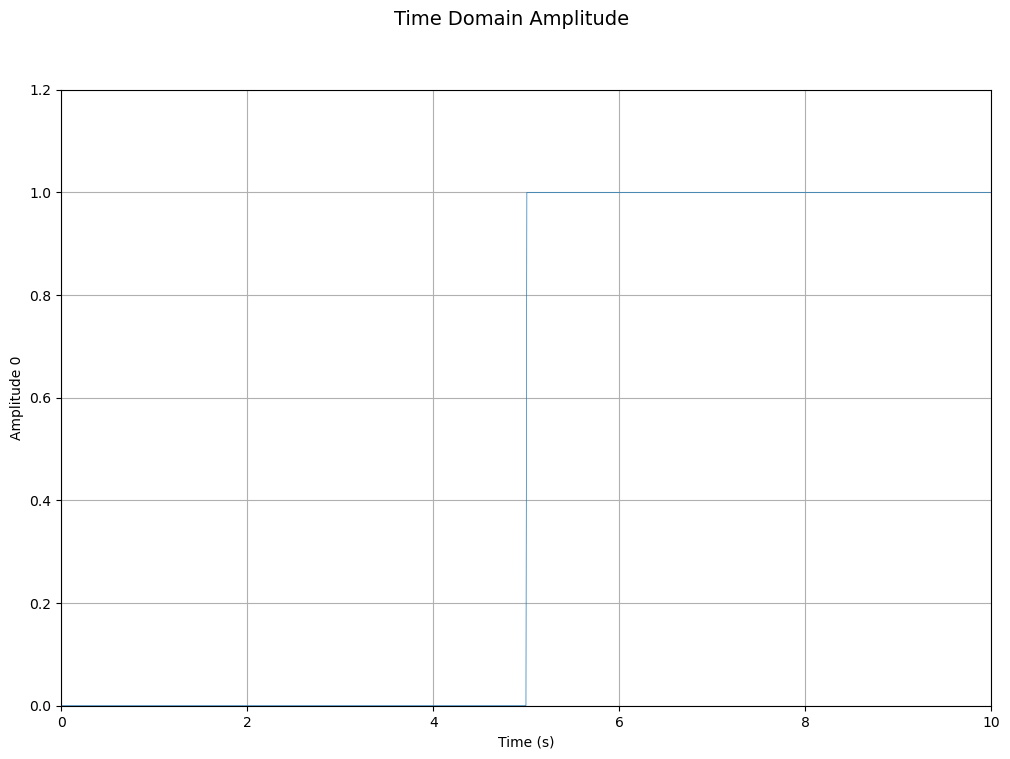

In [27]:
H   = MRPy.Heaviside(NX=1, N=1024, t0=5, Td=10)
f03 = H.plot_time()


### 4.4.  White noise <a name="white_noise"></a>

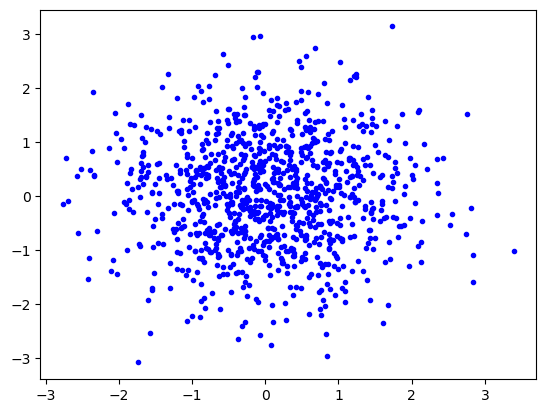

In [28]:
W   = MRPy.white_noise(NX=2, N=1000, Td=10)
f04 = plt.plot(W[0], W[1], 'b.')


### 4.5.  Pink noise <a name="pink_noise"></a>

---
## 5. Further methods for time series analysis <a name="properties"></a>

### 5.3.  Pseudo-spectrum estimation  <a name="pseudo"></a>

### 5.4.  Peak factor by Davenport's formula <a name="Davenport"></a>

### 5.5.  Peak factor by splitmax method <a name="splitmax"></a>

---
## 6. General utilities  <a name="extras"></a>

### 6.1.  Plot axis generation <a name="axis"></a>

### 6.2.  Pre-visualization plots <a name="plots"></a>

### 6.3.  Save to file <a name="to_file"></a>

In [29]:
X.to_file('myfile')
Y = MRPy.from_file('myfile')

X.printAttrib()
Y.printAttrib()

 fs = 512.0Hz
 Td = 32.0s

 NX = 3
 N  = 16384
 M  = 8193

 fs = 512.0Hz
 Td = 32.0s

 NX = 3
 N  = 16384
 M  = 8193



In [30]:
X.to_file('myfile', form='excel')
Y = MRPy.from_file('myfile', form='excel')

X.printAttrib()
Y.printAttrib()

 fs = 512.0Hz
 Td = 32.0s

 NX = 3
 N  = 16384
 M  = 8193

 fs = 512.0Hz
 Td = 32.0s

 NX = 3
 N  = 16384
 M  = 8193



### 6.4.  Periodogram to autocovariance conversions <a name="sx2cx"></a>

### 6.5.  Wind speed turbulence spectra <a name="wind_spectra"></a>



### 6.6. UBC pseudo-spectrum for seismic acceleration <a name="UBC_spectrum"></a>
 
As provided by UBC, the seismic acceleration pseudo spectrum depends on only two parameters: $C_a$ and $C_v$, as can be seen in the diagram below:

<img src="resources/UBC1997_Spectrum.png" alt="UBC1997_Spectrum" width="480px"/>


---
## 7. Examples of application <a name="examples"></a>

###   7.1. Modal analysis of structural systems <a name="modal"></a>

###   7.2. Wind turbulence response by NBR-6123 <a name="NBR6123"></a>

###   7.3. Seismic response by UBC-1997  <a name="UBC1997"></a>

---